# Testing the ability to distinguish signal events from background

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

### Record (Raw) Wire Features 

In [3]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Signal like or not (apriori)
sig_like = numpy.vstack(hits.get_prob_sig_wire(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [4]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Preapre Neighbour Features

In [5]:
# Sum of energy desposits of neighbours 
sum_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T).T
# Sum of neighbouring neighbour deposits (smoothed clustering)
sum_neigh_deposits_2 = hits.cydet.point_neighbours.dot(sum_neigh_deposits.T).T
sum_neigh_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# Number of neighbours with hits
num_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T > 0).T
# Number of signal-like neighbours
sig_like_neighs = hits.cydet.point_neighbours.dot(sig_like.T).T

### Left/Right Neighbour Features

In [6]:
# Sum of energy desposits of left/right neighbours 
sum_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T).T
# Sum of left/right neighbouring left/right neighbour deposits
sum_lr_deposits_2 = hits.cydet.lr_neighbours.dot(sum_neigh_deposits.T).T
sum_lr_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# Number of neighbours with hits
num_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T > 0).T
# Number of signal-like neighbours
sig_like_lr = hits.cydet.lr_neighbours.dot(sig_like.T).T
# Sum of relative timing of left/right neighbours
sum_lr_time = hits.cydet.lr_neighbours.dot(time.T).T
# Get difference measure of time between hit and possible neighbouring hits
diff_lr_time_metric = numpy.vstack(hits.get_time_neighbours_metric(i) for i in range(hits.n_events))

In [7]:
diff_lr_time_metric = numpy.log(diff_lr_time_metric)

/home/elg112/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


## Train/test splitting 

In [8]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(len(labels)), train_size=0.05, test_size=0.05)

In [9]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['time'] = time
features['layer_id'] = layer_id
# Neighbour Features
features['sum_neigh_deposits'] = sum_neigh_deposits * 100
features['num_neigh_deposits'] = num_neigh_deposits
features['sum_neigh_deposits_2'] = sum_neigh_deposits_2
features['sig_like_neighs'] = sig_like_neighs
# Left-Right neighbour features
features['sum_lr_deposits'] = sum_lr_deposits * 100
features['sum_lr_time'] = sum_lr_time
features['num_lr_deposits'] = num_lr_deposits
features['sum_lr_deposits_2'] = sum_lr_deposits_2
features['sig_like_lr'] = sig_like_lr
features['diff_lr_time_metric'] = diff_lr_time_metric
# Truth values
features['labels'] = labels

In [10]:
train_features = features.keys()[:-1]

In [11]:
data = numpy.dstack(features.values())

In [12]:
data.shape

(3445, 4482, 14)

In [13]:
n_feats = data.shape[-1]
train_data, test_data = data[train_events].reshape(-1, n_feats), data[test_events].reshape(-1, n_feats)

In [14]:
import pandas
train_data = pandas.DataFrame(data=train_data, columns=features.keys())
test_data = pandas.DataFrame(data=test_data, columns=features.keys())

### Purge out cells with no hits, relabel 1 as signal hit, 0 as background hit

In [15]:
train_data = train_data[train_data['labels'] != 0]
test_data = test_data[test_data['labels'] != 0]

train_data['labels'] = 2 - train_data['labels']
test_data['labels'] = 2 - test_data['labels']

## Using simple GBRT to determine if wire is signal

In [16]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
factory = ClassifiersFactory()
gb_all_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
gb_deposit = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=['deposit'])
factory.add_classifier('All Features', gb_all_features)
factory.add_classifier('Energy Deposit', gb_deposit)

In [18]:
factory.fit(train_data, train_data['labels'])
pass

model All Features was trained in 22.42 seconds
model Energy Deposit was trained in 3.63 seconds
Totally spent 26.04 seconds on training


In [19]:
predictions = factory.test_on(test_data, test_data['labels'])

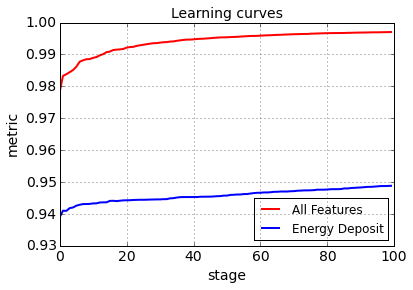

In [20]:
from rep.report.metrics import RocAuc
predictions.learning_curve(RocAuc(), steps=1)

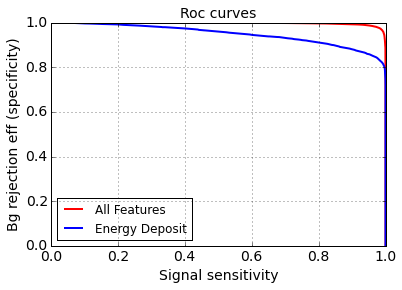

In [21]:
predictions.roc()

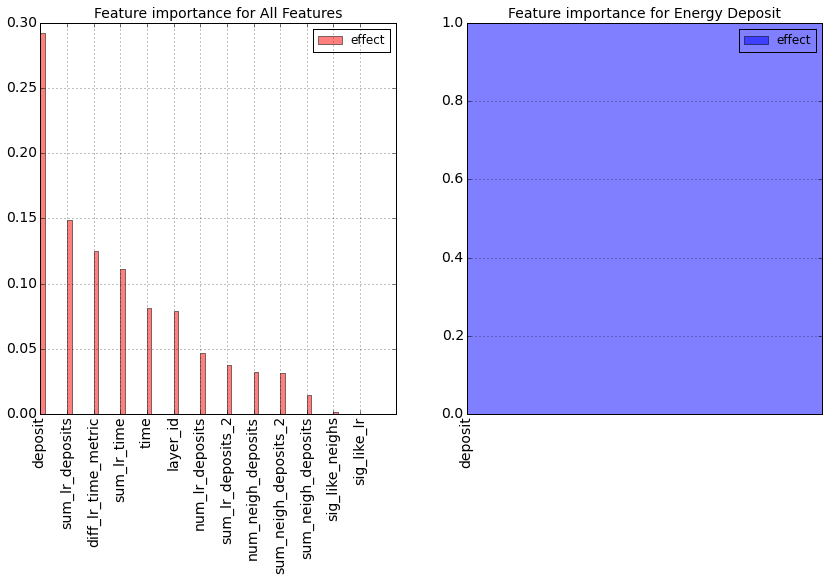

In [22]:
predictions.feature_importance().plot(figsize=[14, 7])

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


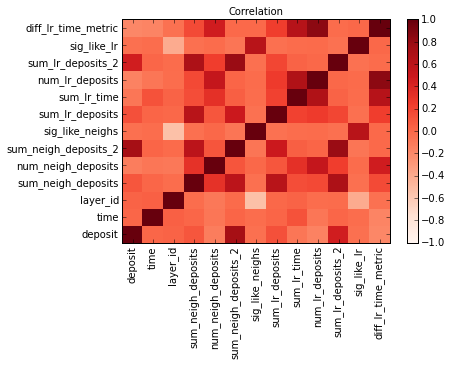

In [23]:
predictions.features_correlation_matrix(features=train_features)

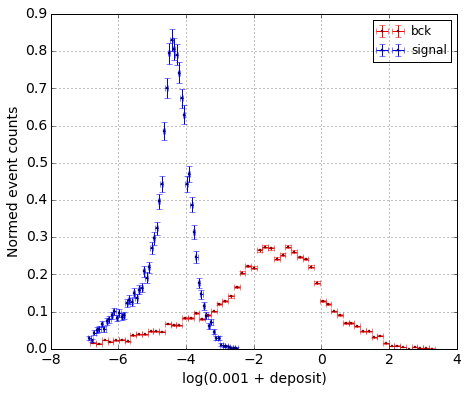

In [24]:
predictions.features_pdf(features=['log(0.001 + deposit)'], bins=60)

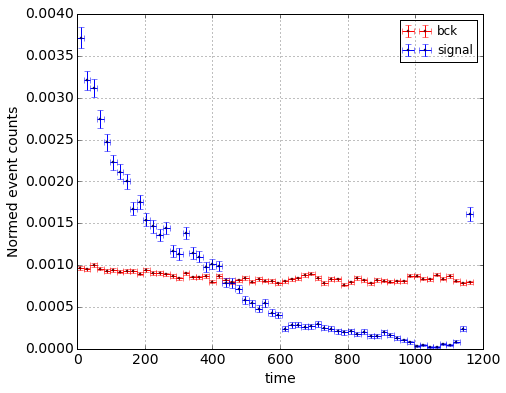

In [25]:
predictions.features_pdf(features=['time'], bins=60)

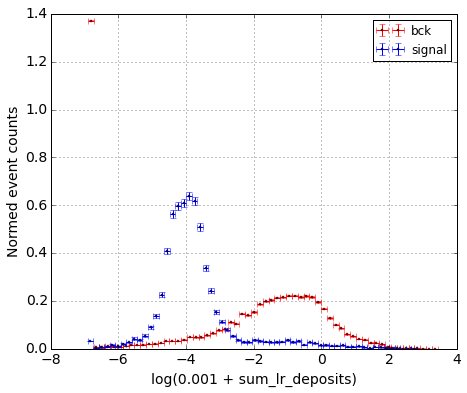

In [26]:
predictions.features_pdf(features=['log(0.001 + sum_lr_deposits)'], bins=60)

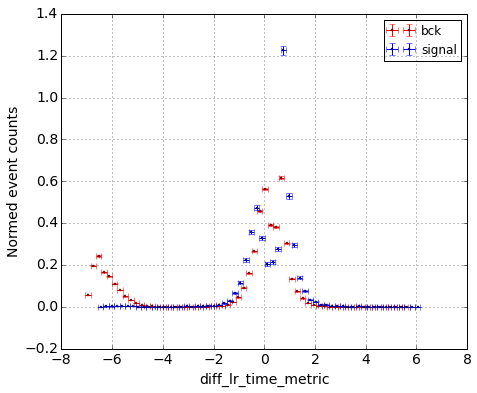

In [27]:
predictions.features_pdf(features=['diff_lr_time_metric'], bins=60)

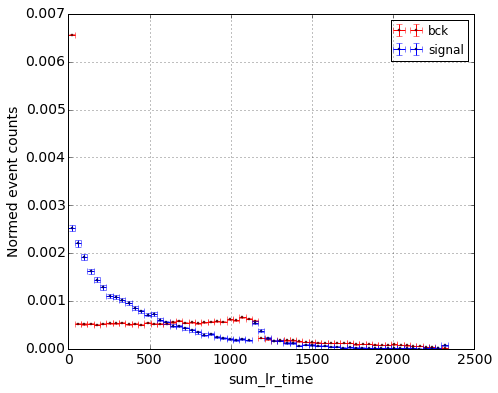

In [28]:
predictions.features_pdf(features=['sum_lr_time'], bins=60)

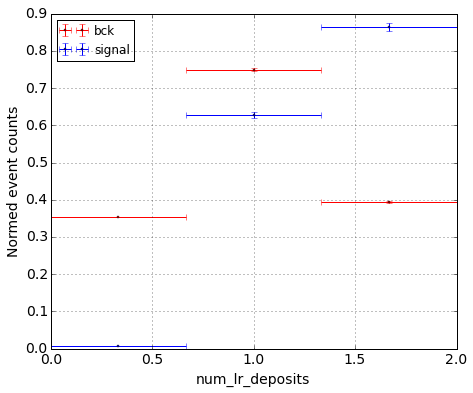

In [29]:
predictions.features_pdf(features=['num_lr_deposits'], bins=3)

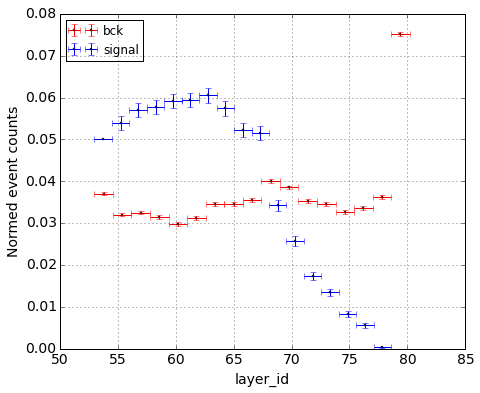

In [30]:
predictions.features_pdf(features=['layer_id'], bins=17)

### Original Background Regection/Singal Retention at 5 KeV

In [31]:
n_sig = 0 
n_sig_pass = 0
n_bkg = 0 
n_bkg_pass = 0
for evt in range(hits.n_events):
        sig_wires = hits.get_sig_wires(evt)
        sig_wires_pass = where(hits.get_energy_deposits(evt)[sig_wires] < 0.000005)[0]
        n_sig += len(sig_wires)
        n_sig_pass += len(sig_wires_pass)
        
        bkg_wires = hits.get_bkg_wires(evt)
        bkg_wires_pass = where(hits.get_energy_deposits(evt)[bkg_wires] < 0.000005)[0]
        n_bkg += len(bkg_wires)
        n_bkg_pass += len(bkg_wires_pass)
print "Signal Retention Rate {}".format(n_sig_pass/float(n_sig))
print "Background Rejection Rate {}".format(n_bkg_pass/float(n_bkg))

# Save these values for comparison later
tpr_orig = n_sig_pass/float(n_sig)
fpr_orig = n_bkg_pass/float(n_bkg)

Signal Retention Rate 0.99706385438
Background Rejection Rate 0.20393287988


In [32]:
from sklearn.metrics import roc_curve
new_tpr = 0.99
new_fpr = 0.10
p = predictions.prediction['All Features'][:, 1]
fpr, tpr, thresholds = roc_curve(test_data['labels'], p)
tpr_orig_index =  where(tpr > tpr_orig)[0][1]
fpr_orig_index =  where(fpr > fpr_orig)[0][1]

tpr_new_index =  where(tpr > new_tpr)[0][1]
fpr_new_index =  where(fpr > new_fpr)[0][1]

print "At signal retetion rate at 5 KeV cut, {0:.5f} , background regjection has changed from".format(tpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_orig_index],fpr_orig-fpr[tpr_orig_index]) + \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_orig_index]))
print "At background retetion rate at 5 KeV cut, {0:.5f} , signal retention has changed from".format(1-fpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_orig_index], tpr[fpr_orig_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_orig_index]))

print "At new signal retention of {0:.5f}, background regjection has changed from".format(new_tpr) + \
      "\n{0:.5f} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_new_index], fpr_orig-fpr[tpr_new_index])+ \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_new_index]))
print "At new background rejection rate of {0:.5f}, signal retention has changed from".format(new_fpr) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_new_index], tpr[fpr_new_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_new_index]))


At signal retetion rate at 5 KeV cut, 0.99706 , background regjection has changed from
0.79607 to 0.93575 improving by 0.13968 or factor 3.17

At background retetion rate at 5 KeV cut, 0.79607 , signal retention has changed from
0.99706 to 0.99992 improving by 0.00286 or factor 38.55

At new signal retention of 0.99000, background regjection has changed from
0.79607 to 0.96578 improving by 0.16971 or factor 5.96

At new background rejection rate of 0.10000, signal retention has changed from
0.99706 to 0.99893 improving by 0.00187 or factor 2.75

